In [1]:
# Import PyTorch
import torch
torch.backends.cudnn.benchmark = True

from torch import nn
from torch.cuda.amp import autocast, GradScaler

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
mlxtend version: 0.23.4


'cpu'

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [3]:
image, label = train_data[0]

class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Image shape: torch.Size([3, 32, 32])


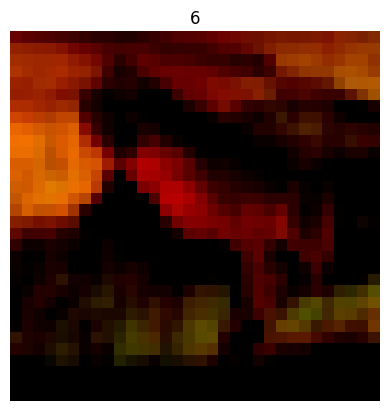

In [4]:
import matplotlib.pyplot as plt
image, label = train_data[torch.randint(0, len(train_data), size=[1]).item()]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
plt.title(label);
plt.axis("off")
plt.show()

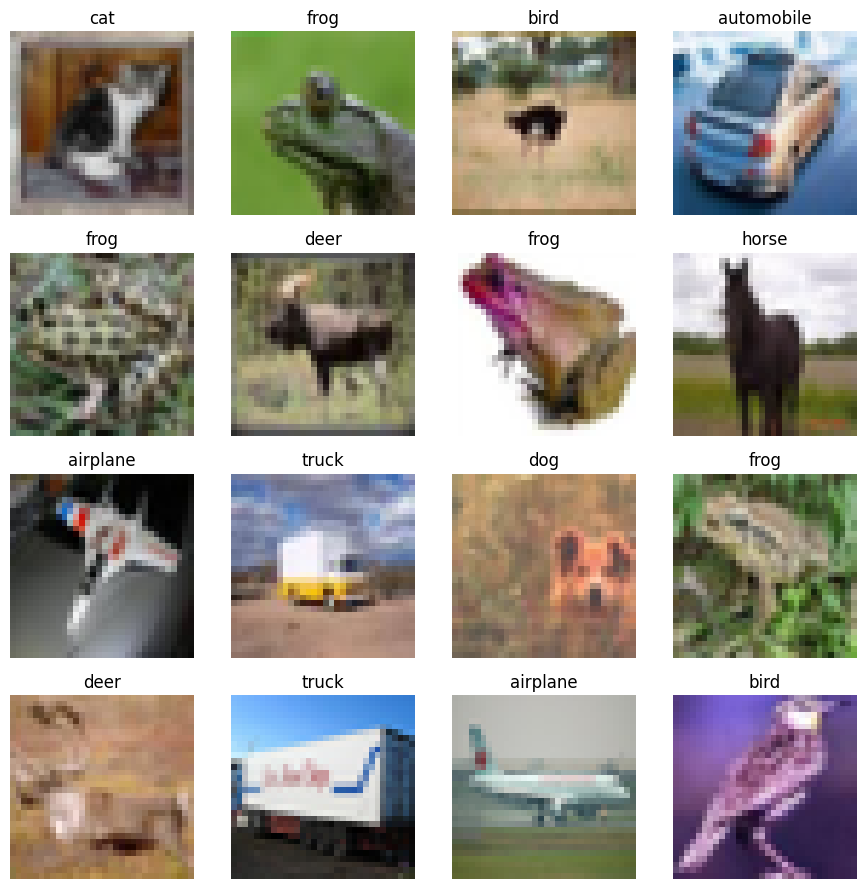

In [19]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    # Unnormalize the image
    img = img * 0.5 + 0.5  # reverse normalization

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []

    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Send the model to the device as well
            model.to(device)

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True, # shuffle data every epoch?
    num_workers = 4,
    pin_memory=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # don't necessarily have to shuffle the testing data
    num_workers = 4,
    pin_memory=True
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f61f735a4d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f61f73e3490>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [9]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [31]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # -----------------------------------------------------------------------------
        # 1) First conv: 5×5, stride=1, pad=2 → preserves 32×32
        # 2) Then three blocks of conv+pool that bring you down to 3×3 at the end
        # -----------------------------------------------------------------------------
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),  # 32→32
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),                 # 32→15

            nn.Conv2d(96, 256, kernel_size=5, padding=2),          # 15→15
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),                 # 15→7

            nn.Conv2d(256, 384, kernel_size=3, padding=1),         # 7→7
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),         # 7→7
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),         # 7→7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                 # 7→3
        )

        # Final map is [256 × 3 × 3], so:
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 3 * 3, 4096),  # <--- changed here
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self._init_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def _init_weights(self):
        # conv init
        for m in self.features:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        # replicate your “bias=1” tweaks if you like:
        nn.init.constant_(self.features[4].bias, 1)
        nn.init.constant_(self.features[8].bias, 1)
        nn.init.constant_(self.features[10].bias, 1)

        # fc init
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Instantiate
model = AlexNetCIFAR(num_classes=10).to(device)

In [32]:
# Make predictions on test samples with model
pred_probs = make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.0996, 0.0964, 0.1044, 0.0976, 0.1024, 0.1002, 0.0980, 0.1013, 0.1075,
         0.0925],
        [0.0996, 0.0963, 0.1044, 0.0976, 0.1024, 0.1003, 0.0980, 0.1013, 0.1075,
         0.0925]])

In [33]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
# Corrected train_step function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    model.train()
    torch.set_grad_enabled(True)

    train_loss, train_acc = 0, 0
    scaler = GradScaler()

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass and loss calculation within autocast for mixed precision
        with autocast():
          y_pred = model(X)
          loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad - MOVED BEFORE backward pass
        optimizer.zero_grad()

        # 4. Loss backward (handled by scaler)
        scaler.scale(loss).backward()

        # 5. Optimizer step (handled by scaler)
        scaler.step(optimizer)
        scaler.update()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

# The test_step function remains the same as it doesn't involve optimization
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 30
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    scheduler.step()

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
# Plot random predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

# Get random sample indices
random_indices = random.sample(range(len(test_data)), k=nrows * ncols)

for i, sample_idx in enumerate(random_indices):
    # Get a random sample and its truth label
    sample, truth_label_idx = test_data[sample_idx]

    # Unnormalize the sample
    sample = sample * 0.5 + 0.5  # reverse normalization

    # Make a prediction on the random sample
    pred_prob_sample = make_predictions(model=model, data=[sample])
    pred_class_sample = pred_prob_sample.argmax(dim=1)
    pred_label = class_names[pred_class_sample]

    # Get the truth label in text form
    truth_label = class_names[truth_label_idx]

    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image, permuting dimensions to (H, W, C) for matplotlib
    plt.imshow(sample.permute(1, 2, 0))

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_preds = []
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1).cpu()          # class indices
        y_preds.append(preds)
y_pred_tensor = torch.cat(y_preds)                # shape [10000]

# Convert true labels to a tensor
test_targets_tensor = torch.tensor(test_data.targets, dtype=torch.long)

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch # Ensure torch is imported if not already in this cell

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Convert test_data.targets from a list to a torch tensor
# Ensure both predictions and targets are of type long
test_targets_tensor = torch.tensor(test_data.targets).long()
y_pred_tensor = y_pred_tensor.long() # Explicitly cast predictions to long

# --- Add inspection code here ---
unique_preds, counts = torch.unique(y_pred_tensor, return_counts=True)
print(f"Unique values in y_pred_tensor: {unique_preds}")
print(f"Counts of unique values: {counts}")
# --- End inspection code ---


confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_targets_tensor) # Pass the tensor version of targets

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
# ----------------------------- CUSTOM -----------------------------

from PIL import Image

image_path = "custom_enes.png"

# Define the same transform used in training
custom_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load and transform the image
custom_image = Image.open(image_path).convert("RGB")
custom_tensor = custom_transform(custom_image)

In [ ]:
# Make prediction
model.eval()
with torch.inference_mode():
    input_tensor = custom_tensor.unsqueeze(0).to(device)  # Add batch dim and send to device
    output_logits = model(input_tensor)
    pred_probs = torch.softmax(output_logits, dim=1)
    pred_label_idx = pred_probs.argmax(dim=1).item()

# Print the result
print(f"Predicted class: {class_names[pred_label_idx]}")

In [ ]:
plt.imshow(custom_image)
plt.title(f"Predicted: {class_names[pred_label_idx]}")
plt.axis("off")
plt.show()

In [ ]:
# Specify a file path within the /content/ directory
model_save_path = '/content/alexnet_cifar10.pth'

# Save the model state dictionary to the specified file path
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")